In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan, isnull, mean
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("TelcoChurnAnalysis") \
    .getOrCreate()

# Load data
df = spark.read.csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv", header=True, inferSchema=True)

In [ ]:
def preprocess_data(df):
    # Drop unnecessary columns
    df = df.drop("customerID")  # Drop unique identifier as it's not useful for the model

    # Handle missing or invalid values in 'TotalCharges'
    df = df.withColumn("TotalCharges",
                       when(col("TotalCharges") == "", None).otherwise(col("TotalCharges").cast("double")))
    df = df.na.fill({"TotalCharges": 0})  # Replace nulls in TotalCharges with 0 (or mean if preferred)

    # Separate numeric and string columns
    numeric_columns = [field.name for field in df.schema.fields if field.dataType.typeName() in ['double', 'integer']]
    string_columns = [field.name for field in df.schema.fields if field.dataType.typeName() == 'string']

    # Replace nulls in numeric columns with the mean
    for column in numeric_columns:
        mean_value = df.select(mean(col(column))).collect()[0][0]
        df = df.na.fill({column: mean_value})

    # Replace nulls in string columns with 'unknown'
    for column in string_columns:
        df = df.na.fill({column: 'unknown'})

    # Convert 'Yes'/'No' columns to binary
    binary_columns = ['Churn', 'PhoneService', 'PaperlessBilling']
    for column in binary_columns:
        df = df.withColumn(column, when(col(column) == 'Yes', 1).otherwise(0))

    return df


In [ ]:
def perform_eda(df):
    # Convert to pandas for visualization
    pdf = df.toPandas()

    # Get numeric and categorical columns
    numeric_columns = [field.name for field in df.schema.fields
                      if field.dataType.typeName() in ['double', 'integer']]
    categorical_columns = [field.name for field in df.schema.fields
                         if field.dataType.typeName() == 'string']

    # Plot distribution of numeric columns
    plt.figure(figsize=(15, 5*len(numeric_columns)))
    for i, col in enumerate(numeric_columns, 1):
        plt.subplot(len(numeric_columns), 1, i)
        sns.histplot(data=pdf, x=col)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

    # Plot categorical columns
    plt.figure(figsize=(15, 5*len(categorical_columns)))
    for i, col in enumerate(categorical_columns, 1):
        plt.subplot(len(categorical_columns), 1, i)
        pdf[col].value_counts().plot(kind='bar')
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

    # Print basic statistics
    print("\nNumeric Columns Summary:")
    df.select(numeric_columns).summary().show()

    print("\nCategorical Columns Value Counts:")
    for col in categorical_columns:
        print(f"\n{col}:")
        df.groupBy(col).count().orderBy('count', ascending=False).show()

In [ ]:
def prepare_features(df):
    # List of categorical columns to be indexed
    categorical_columns = [col for col in df.columns if df.select(col).dtypes[0][1] == 'string']

    # Create indexers for each categorical column
    indexers = [StringIndexer(inputCol=column, outputCol=f"{column}_indexed", handleInvalid="keep")
                for column in categorical_columns]

    # Create list of feature columns
    feature_columns = [c + "_indexed" for c in categorical_columns]
    feature_columns.extend([c for c in df.columns if c not in categorical_columns + ['Churn']])

    # Create vector assembler
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="keep")

    # Create pipeline
    pipeline = Pipeline(stages=indexers + [assembler])

    # Fit and transform the data
    prepared_df = pipeline.fit(df).transform(df)

    # Select only needed columns and rename Churn to label
    final_df = prepared_df.select("features", col("Churn").alias("label"))

    return final_df

In [ ]:
def plot_confusion_matrix(predictions_df, model_name):
    # Convert predictions to pandas
    pred_pd = predictions_df.select(['label', 'prediction']).toPandas()

    # Create confusion matrix
    cm = pd.crosstab(pred_pd['label'], pred_pd['prediction'])

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
def train_models_with_cv(df):
    # Split data
    train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

    # Initialize evaluator
    evaluator = BinaryClassificationEvaluator(
        labelCol="label",
        rawPredictionCol="rawPrediction",
        metricName="areaUnderROC"
    )

    # 1. Logistic Regression with Cross Validation
    lr = LogisticRegression(featuresCol="features", labelCol="label")
    lr_paramGrid = ParamGridBuilder() \
        .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
        .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
        .build()

    lr_cv = CrossValidator(
        estimator=lr,
        estimatorParamMaps=lr_paramGrid,
        evaluator=evaluator,
        numFolds=5
    )
    lr_model = lr_cv.fit(train_data)

    # 2. Random Forest with Cross Validation
    rf = RandomForestClassifier(featuresCol="features", labelCol="label")
    rf_paramGrid = ParamGridBuilder() \
        .addGrid(rf.maxDepth, [5, 10, 15]) \
        .addGrid(rf.numTrees, [10, 20, 30]) \
        .addGrid(rf.maxBins, [16, 32]) \
        .build()

    rf_cv = CrossValidator(
        estimator=rf,
        estimatorParamMaps=rf_paramGrid,
        evaluator=evaluator,
        numFolds=5
    )
    rf_model = rf_cv.fit(train_data)

    # 3. Gradient Boosting with Cross Validation
    gbt = GBTClassifier(featuresCol="features", labelCol="label")
    gbt_paramGrid = ParamGridBuilder() \
        .addGrid(gbt.maxDepth, [3, 5, 7]) \
        .addGrid(gbt.maxIter, [10, 20, 30]) \
        .addGrid(gbt.stepSize, [0.05, 0.1, 0.15]) \
        .build()

    gbt_cv = CrossValidator(
        estimator=gbt,
        estimatorParamMaps=gbt_paramGrid,
        evaluator=evaluator,
        numFolds=5
    )
    gbt_model = gbt_cv.fit(train_data)

    return lr_model, rf_model, gbt_model, test_data

In [ ]:
def evaluate_models_enhanced(lr_model, rf_model, gbt_model, test_data):
    # Make predictions
    lr_predictions = lr_model.transform(test_data)
    rf_predictions = rf_model.transform(test_data)
    gbt_predictions = gbt_model.transform(test_data)

    # Create evaluators
    binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")
    multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

    # Calculate metrics
    models = {
        'Logistic Regression': lr_predictions,
        'Random Forest': rf_predictions,
        'Gradient Boosting': gbt_predictions
    }

    results = {}
    for model_name, predictions in models.items():
        model_metrics = {
            'AUC-ROC': binary_evaluator.evaluate(predictions),
            'Accuracy': multi_evaluator.setMetricName("accuracy").evaluate(predictions),
            'Precision': multi_evaluator.setMetricName("weightedPrecision").evaluate(predictions),
            'Recall': multi_evaluator.setMetricName("weightedRecall").evaluate(predictions),
            'F1': multi_evaluator.setMetricName("f1").evaluate(predictions)
        }
        results[model_name] = model_metrics

    return results

In [ ]:
def plot_roc_curves(lr_model, rf_model, gbt_model, test_data):
    models = {
        'Logistic Regression': lr_model,
        'Random Forest': rf_model,
        'Gradient Boosting': gbt_model
    }

    plt.figure(figsize=(10, 8))

    for model_name, model in models.items():
        predictions = model.transform(test_data)
        pred_pd = predictions.select(['label', 'probability']).toPandas()

        # Calculate FPR and TPR
        fpr = []
        tpr = []
        thresholds = np.linspace(0, 1, 100)

        for threshold in thresholds:
            fp = ((pred_pd['probability'].apply(lambda x: x[1]) >= threshold) &
                 (pred_pd['label'] == 0)).sum()
            tp = ((pred_pd['probability'].apply(lambda x: x[1]) >= threshold) &
                 (pred_pd['label'] == 1)).sum()
            fn = ((pred_pd['probability'].apply(lambda x: x[1]) < threshold) &
                 (pred_pd['label'] == 1)).sum()
            tn = ((pred_pd['probability'].apply(lambda x: x[1]) < threshold) &
                 (pred_pd['label'] == 0)).sum()

            fpr.append(fp / (fp + tn))
            tpr.append(tp / (tp + fn))

        plt.plot(fpr, tpr, label=model_name)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Models')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def display_best_parameters(lr_model, rf_model, gbt_model):
    models = {
        'Logistic Regression': lr_model,
        'Random Forest': rf_model,
        'Gradient Boosting': gbt_model
    }

    print("\nBest Parameters for Each Model:")
    for model_name, model in models.items():
        print(f"\n{model_name}:")
        best_model = model.bestModel
        for param in best_model.extractParamMap():
            print(f"{param.name}: {best_model.getOrDefault(param)}")

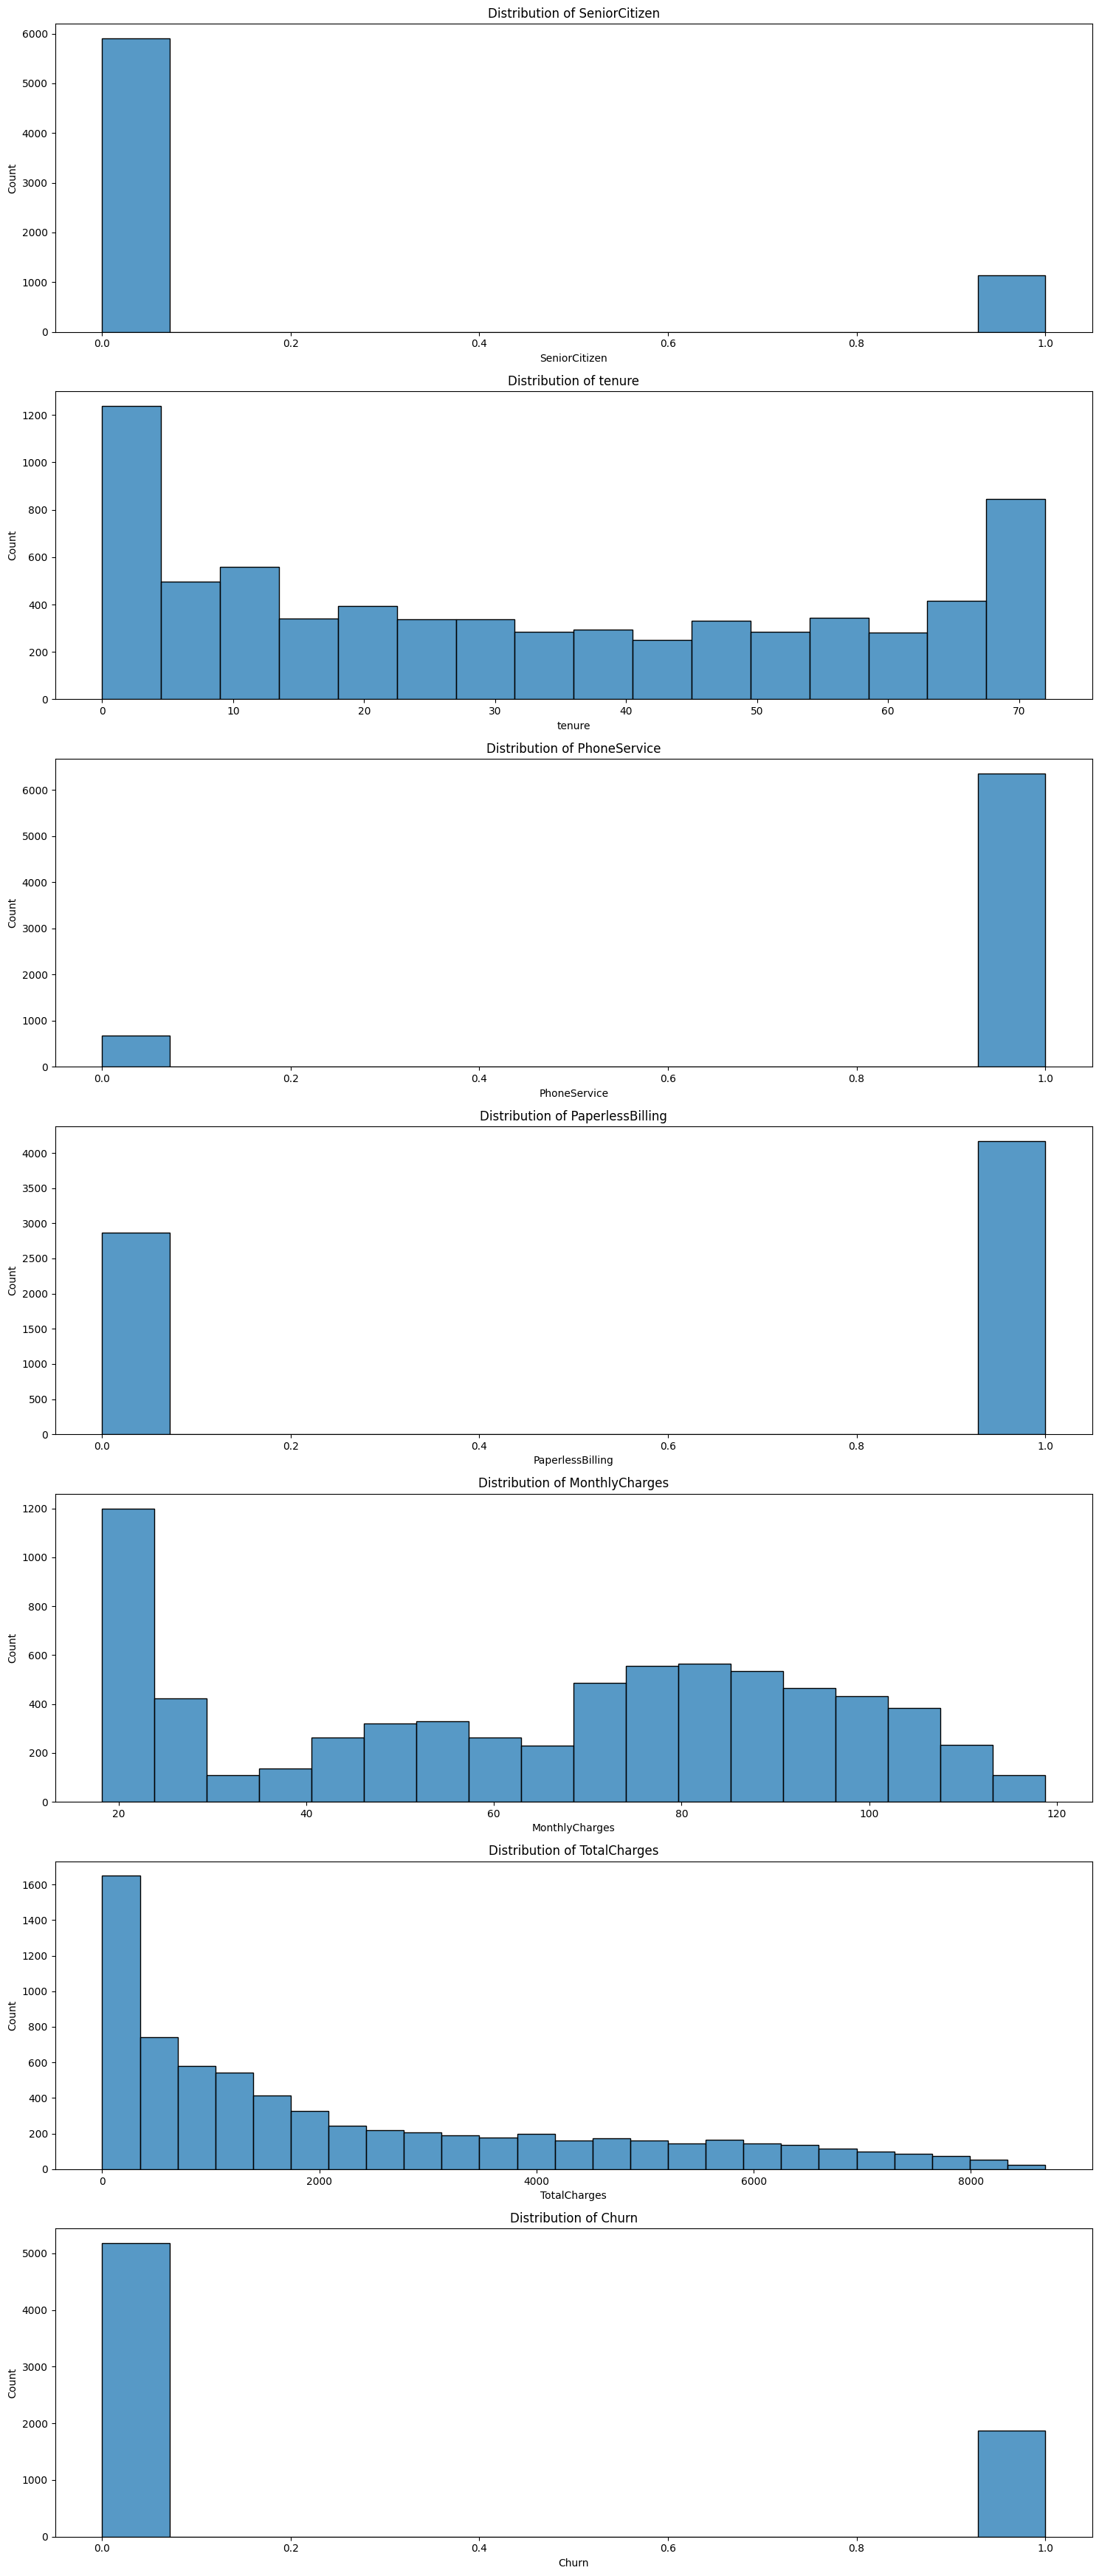

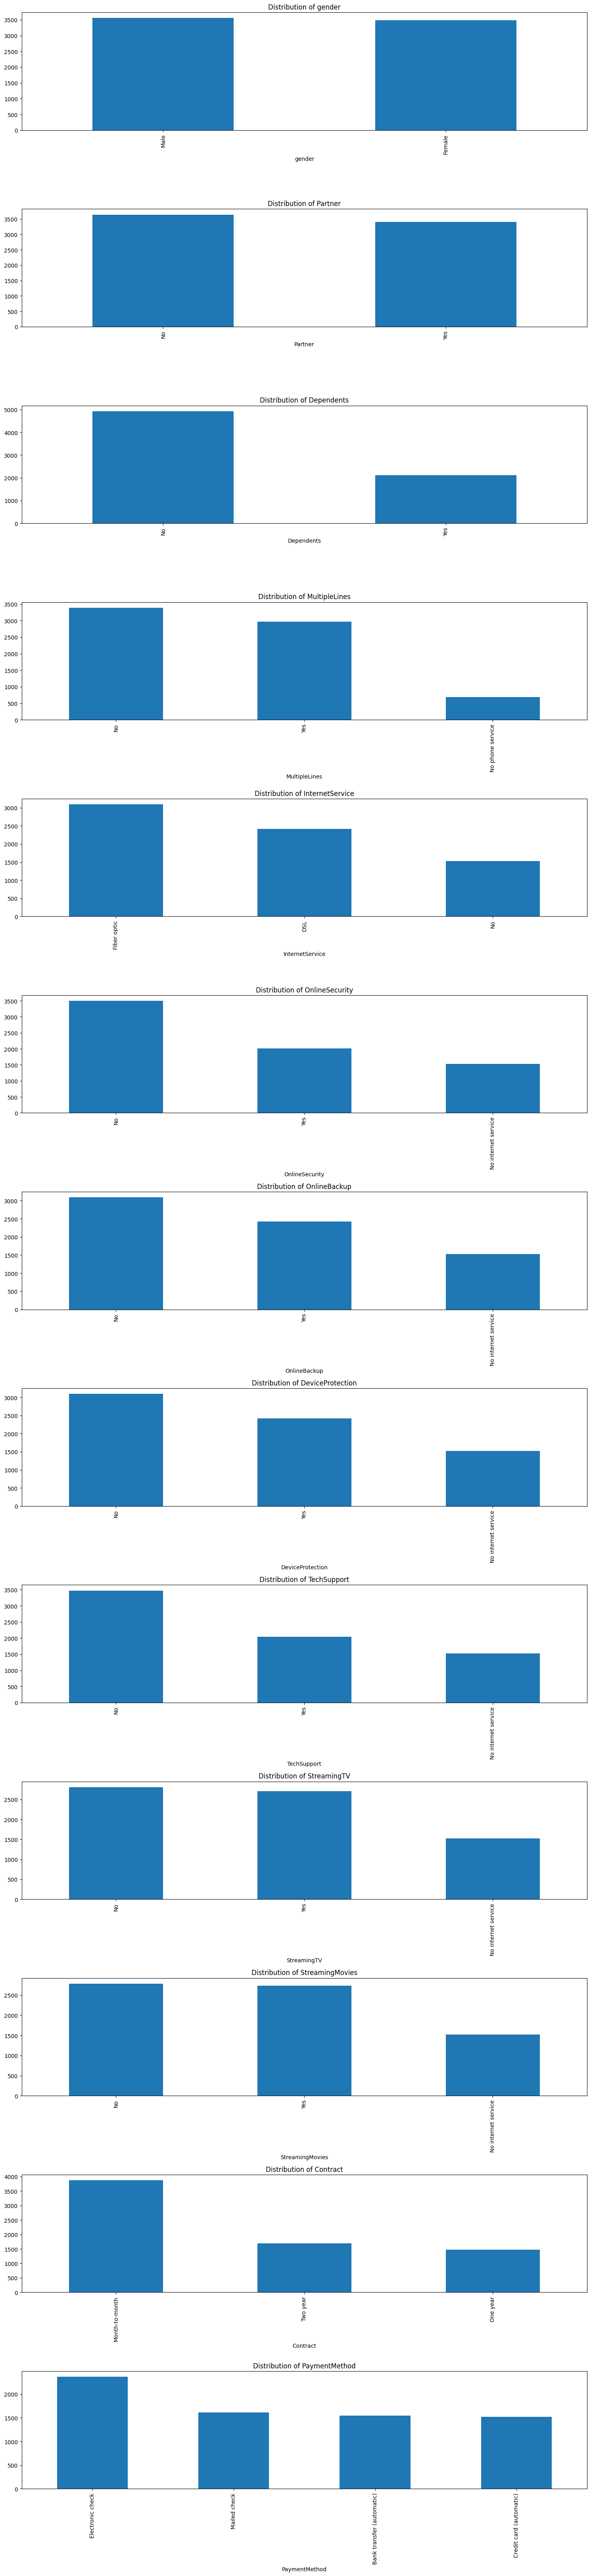


Numeric Columns Summary:
+-------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+
|summary|     SeniorCitizen|            tenure|       PhoneService|  PaperlessBilling|    MonthlyCharges|      TotalCharges|              Churn|
+-------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+
|  count|              7043|              7043|               7043|              7043|              7043|              7043|               7043|
|   mean|0.1621468124378816| 32.37114865824223| 0.9031662643759761|0.5922192247621753| 64.76169246059922| 2279.734303563826| 0.2653698707936959|
| stddev|0.3686116056100135|24.559481023094442|0.29575223178363513|0.4914569240494065|30.090047097678482|2266.7944696890245|0.44156130512194697|
|    min|                 0|                 0|                  0|                 0|             18.25

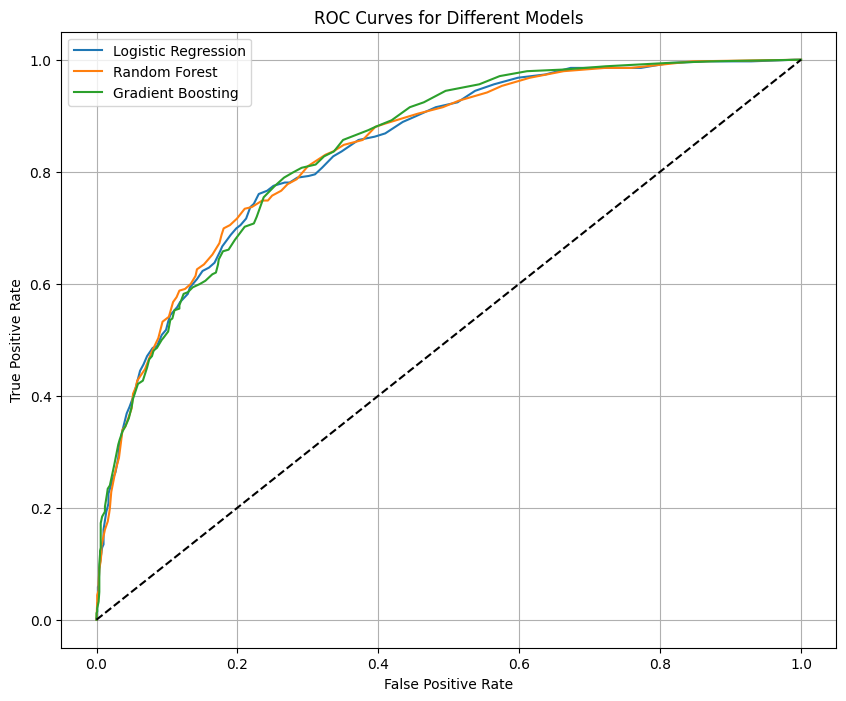

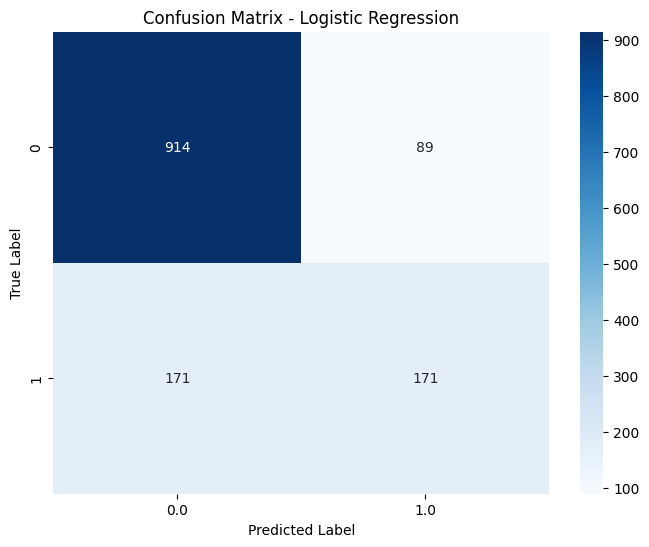

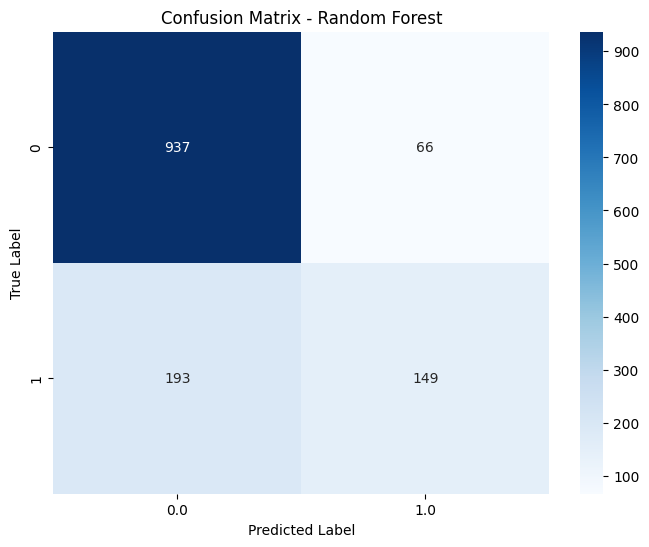

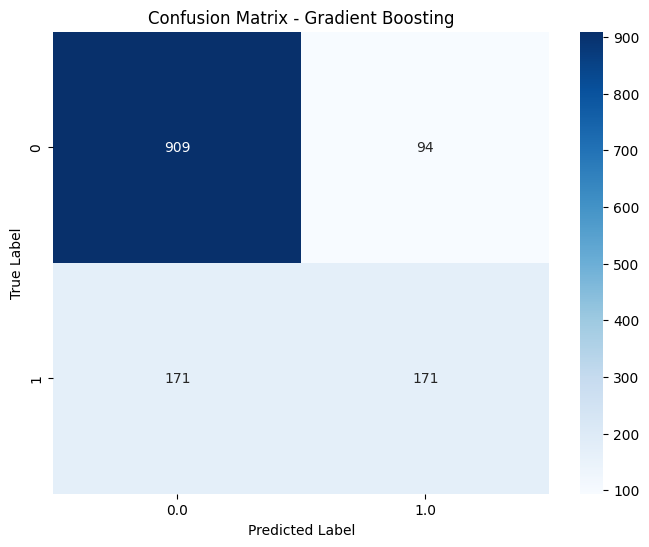

In [ ]:
def main():
    # Preprocess data
    processed_df = preprocess_data(df)

    # Perform EDA
    perform_eda(processed_df)

    # Prepare features
    prepared_df = prepare_features(processed_df)

    # Train models with cross-validation
    lr_model, rf_model, gbt_model, test_data = train_models_with_cv(prepared_df)

    # Display best parameters
    display_best_parameters(lr_model, rf_model, gbt_model)

    # Evaluate models
    results = evaluate_models_enhanced(lr_model, rf_model, gbt_model, test_data)

    # Print results
    print("\nModel Performance Metrics:")
    for model, metrics in results.items():
        print(f"\n{model}:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    # Plot ROC curves
    plot_roc_curves(lr_model, rf_model, gbt_model, test_data)

    # Plot confusion matrices
    for model_name, model in [
        ("Logistic Regression", lr_model),
        ("Random Forest", rf_model),
        ("Gradient Boosting", gbt_model)
    ]:
        plot_confusion_matrix(model.transform(test_data), model_name)

if __name__ == "__main__":
    main()